# Color correction análysis

In [1]:
from exp import *

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
dm = DatasetManager('2017',224,'all','2017')

In [4]:
# dm.generate_dataset('train_images')

# dm.generate_dataset('valid_images')


# Distribución de la media de los canales en el dataset


In [5]:
train_imgs = dm.get_dataset_path('train_images')

len(train_imgs.ls())

mel_imgs_paths = [img_path for img_path in train_imgs.ls() if dm.get_label_for_image_path(img_path) == 'melanoma']
other_imgs_paths = [img_path for img_path in train_imgs.ls() if dm.get_label_for_image_path(img_path) != 'melanoma']

In [6]:
def get_channels_mean_for_image_path(img_path,transforms=[]):
    red_avg, green_avg, blue_avg = open_image(img_path).apply_tfms(transforms).data.mean(dim=(1,2))
    return [red_avg.item(), green_avg.item(), blue_avg.item()]


def get_list_of_channels_mean_for_list_of_image_paths(list_of_image_paths,transforms=[]):
    list_of_channels_mean_per_image = list(map(partial(get_channels_mean_for_image_path,transforms=transforms), list_of_image_paths))
    red_channel_mean_per_image = list(map(lambda means: means[0], list_of_channels_mean_per_image))
    green_channel_mean_per_image = list(map(lambda means: means[1], list_of_channels_mean_per_image))
    blue_channel_mean_per_image = list(map(lambda means: means[2], list_of_channels_mean_per_image))
    return [red_channel_mean_per_image,green_channel_mean_per_image,blue_channel_mean_per_image]



In [7]:
mel_mean_reds, mel_mean_greens, mel_mean_blues = get_list_of_channels_mean_for_list_of_image_paths(mel_imgs_paths)

other_mean_reds, other_mean_greens, other_mean_blues = get_list_of_channels_mean_for_list_of_image_paths(other_imgs_paths)

## Veamos la distribución de los canales en el dataset original de 2017

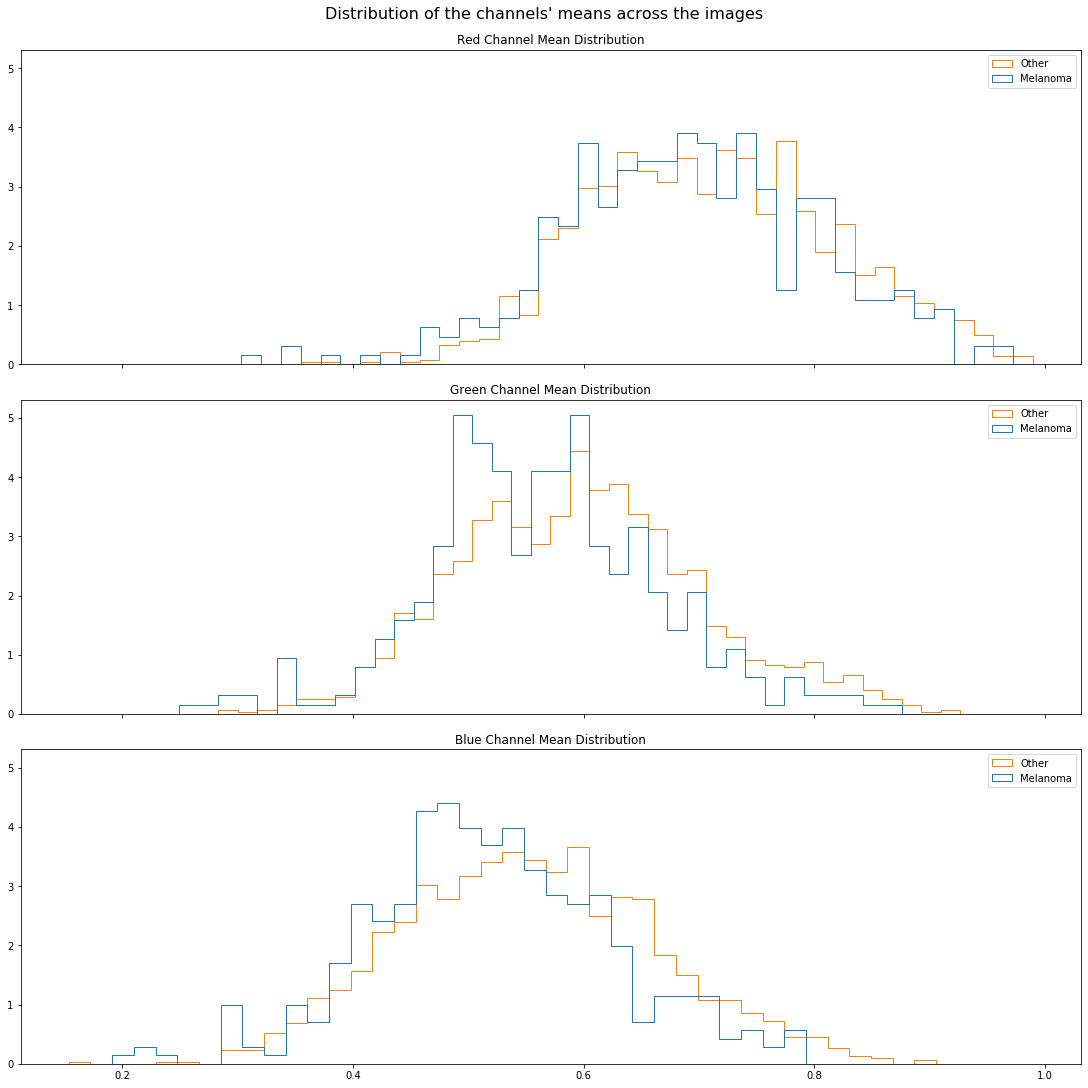

In [8]:
fig, axs = plt.subplots(3, 1, sharex=True, sharey=True,constrained_layout=True, figsize=(15,15))

names = ['Melanoma',"Other"]

for idx,data_point in enumerate(zip([mel_mean_reds, mel_mean_greens, mel_mean_blues],
                                    [other_mean_reds, other_mean_greens, other_mean_blues],
                                    ['Red','Green','Blue'])):
    melanoma, other, channel_name = data_point
    fig.suptitle('Distribution of the channels\' means across the images',fontsize=16)
    axs[idx].hist([melanoma,other],bins=40,histtype='step',density=True,label=names)
    axs[idx].set_title(f'{channel_name} Channel Mean Distribution')
    axs[idx].legend()



## Si aplicamos Max RGB

In [9]:
def calculate_color_constancy_distributions(gamma): 
    max_rgb_channels_mean = partial(get_list_of_channels_mean_for_list_of_image_paths, transforms=[correct_color_max_rgb(gamma=gamma)])

    max_rgb_mel_mean_reds, max_rgb_mel_mean_greens, max_rgb_mel_mean_blues = max_rgb_channels_mean(mel_imgs_paths)

    max_rgb_other_mean_reds, max_rgb_other_mean_greens, max_rgb_other_mean_blues = max_rgb_channels_mean(other_imgs_paths)
    return {'mel': (max_rgb_mel_mean_reds, max_rgb_mel_mean_greens, max_rgb_mel_mean_blues),
           'other': (max_rgb_other_mean_reds, max_rgb_other_mean_greens, max_rgb_other_mean_blues) }


def plot_color_constancy_distributions(gamma):
    means = calculate_color_constancy_distributions(gamma)

    max_rgb_mel_mean_reds, max_rgb_mel_mean_greens, max_rgb_mel_mean_blues = means['mel']

    max_rgb_other_mean_reds, max_rgb_other_mean_greens, max_rgb_other_mean_blues = means['other']


    fig, axs = plt.subplots(3, 1, sharex=True, sharey=True,constrained_layout=True, figsize=(15,15))

    names = ['Melanoma',"Other"]

    for idx,data_point in enumerate(zip([max_rgb_mel_mean_reds, max_rgb_mel_mean_greens, max_rgb_mel_mean_blues],
                                        [max_rgb_other_mean_reds, max_rgb_other_mean_greens, max_rgb_other_mean_blues],
                                        ['Red','Green','Blue'])):
        melanoma, other, channel_name = data_point
        fig.suptitle(f'Distribution of the channels\' means across the images when MAX RGB is applied',fontsize=16)
        axs[idx].hist([melanoma,other],bins=40,histtype='step',density=True,label=names)
        axs[idx].set_title(f'{channel_name} Channel Mean Distribution')
        axs[idx].legend()

In [10]:
interact(plot_color_constancy_distributions, gamma=widgets.FloatSlider(min=1/2.2, max=2.2,step=.01,    continuous_update=False
))

interactive(children=(FloatSlider(value=0.45454545454545453, continuous_update=False, description='gamma', max…

<function __main__.plot_color_constancy_distributions(gamma)>

## Comparando

In [13]:
def plot_comparison_with_and_without_color_constancy(gamma):
    means = calculate_color_constancy_distributions(gamma)

    max_rgb_mel_mean_reds, max_rgb_mel_mean_greens, max_rgb_mel_mean_blues = means['mel']

    max_rgb_other_mean_reds, max_rgb_other_mean_greens, max_rgb_other_mean_blues = means['other']


    baseline_reds = mel_mean_reds + other_mean_reds
    baseline_greens = mel_mean_greens + other_mean_greens
    baseline_blues = mel_mean_blues + other_mean_blues


    max_rgb_reds = max_rgb_mel_mean_reds + max_rgb_other_mean_reds
    max_rgb_greens = max_rgb_mel_mean_greens + max_rgb_other_mean_greens
    max_rgb_blues = max_rgb_mel_mean_blues + max_rgb_other_mean_blues


    

    img = open_image(train_imgs.ls()[0])
    img.show()
    img.apply_tfms(correct_color_max_rgb(gamma=gamma)).show()
    
    

    fig, axs = plt.subplots(3, 1, sharex=True, sharey=True,constrained_layout=True, figsize=(15,15))

    names = ['Baseline',"Max RGB"]

    for idx,data_point in enumerate(zip([baseline_reds, baseline_greens, baseline_blues],
                                        [max_rgb_reds, max_rgb_greens, max_rgb_blues],
                                        ['Red','Green','Blue'])):
        melanoma, other, channel_name = data_point
        fig.suptitle('Comparing distributions with and without the effect of Max RGB',fontsize=16)
        axs[idx].hist([melanoma,other],bins=40,histtype='step',density=True,label=names)
        axs[idx].set_title(f'{channel_name} Channel Mean Distribution')
        axs[idx].legend()
    
    
    

In [14]:
interact(plot_comparison_with_and_without_color_constancy, gamma=widgets.FloatSlider(min=1/2.2, max=2.2,step=.01,    continuous_update=False
))

interactive(children=(FloatSlider(value=0.45454545454545453, continuous_update=False, description='gamma', max…

<function __main__.plot_comparison_with_and_without_color_constancy(gamma)>

# Takeaway

Utilizar un gamma de valor 1/2.2 parece reducir la varianza en la media de los canales de las imágenes

# Training a Model

In [4]:
'Número Imágenes de entrenamiento:', len(dm.get_dataset_path('train_images').ls())

('Número Imágenes de entrenamiento:', 2000)

In [5]:
'Número Imágenes de validación:', len(dm.get_dataset_path('valid_images').ls())

('Número Imágenes de validación:', 150)

In [40]:
def reload_dataset(dm,segmented=False, seed=1):
    random_seed(seed,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.3, max_lighting=0.3,p_affine=1, max_warp=0)
    data = ImageList.from_folder(dm.get_dataset_path('train_images').parent)\
    .split_by_folder(train=dm.get_dataset_path('train_images').name + ('_segmented' if segmented else ''),
                   valid=dm.get_dataset_path('valid_images').name +('_segmented' if segmented else ''))\
    .label_from_func(dm.get_label_for_image_path)\
    .transform(tfms,size=128)\
    .databunch(bs=16)\
    .normalize(imagenet_stats)
    return data

data = reload_dataset(dm)

In [10]:
Path('ben_2017_train_images_resized_to_224_picked_all_training_for_2017/').parent

PosixPath('.')

In [32]:
def reload_dataset_ben(dm,segmented=False, seed=1):
    random_seed(seed,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.3, max_lighting=0.0,p_affine=1, max_warp=0)
    data = ImageList.from_folder(Path('ben_2017_train_images_resized_to_224_picked_all_training_for_2017/').parent)\
    .split_by_folder(train=Path('ben_2017_train_images_resized_to_224_picked_all_training_for_2017/').name + ('_segmented' if segmented else ''),
                   valid=Path('ben_2017_valid_images_resized_to_224_picked_all_training_for_2017/').name +('_segmented' if segmented else ''))\
    .label_from_func(dm.get_label_for_image_path)\
    .transform(tfms,size=128)\
    .databunch(bs=16)\
    .normalize(imagenet_stats)
    return data

data = reload_dataset_ben(dm)

In [33]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

train_count: 
 seborrheic_keratosis_or_nevus    1626
melanoma                          374
dtype: int64 

 valid_count: 
 seborrheic_keratosis_or_nevus    120
melanoma                          30
dtype: int64
ratios:
seborrheic_keratosis_or_nevus    0.073801
melanoma                         0.080214
dtype: float64 %


## Show color correction changes

### Baseline

In [41]:
data = reload_dataset(dm)

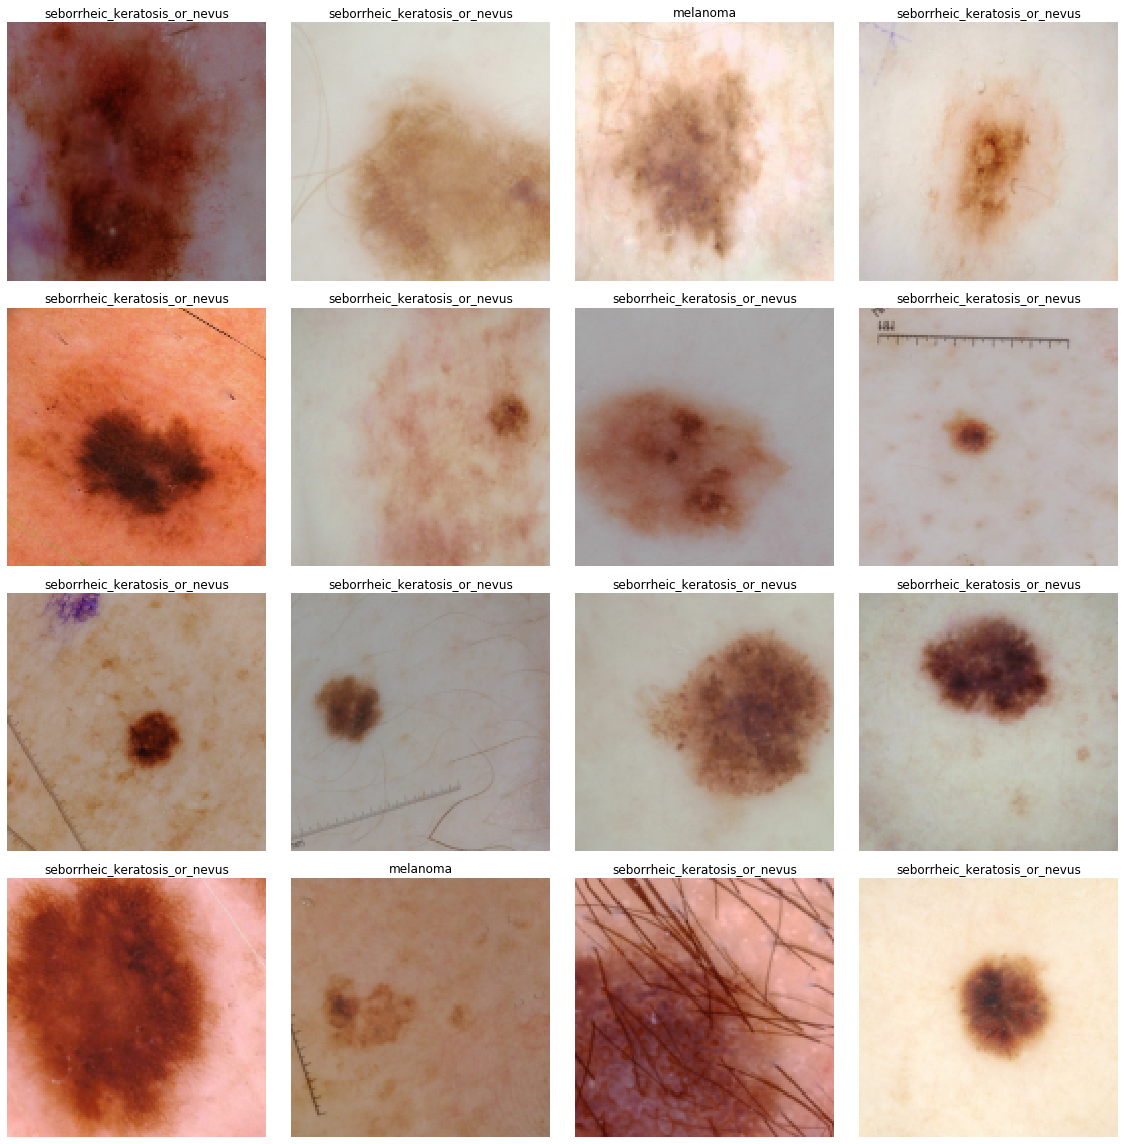

In [42]:
random_seed(1,True)
data.show_batch()

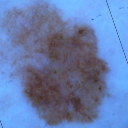

In [30]:
random_seed(1,True)
data.train_ds[1][0]

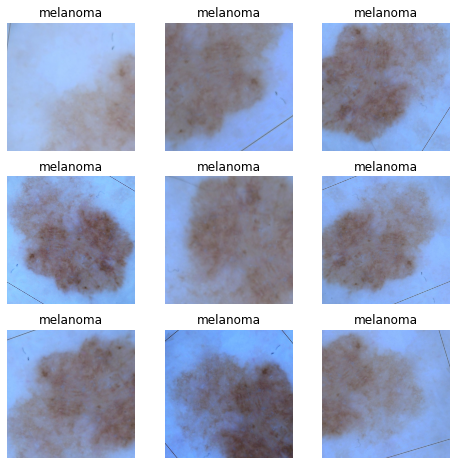

In [31]:
plot_multi(partial(_plot,img_index=1), 3, 3, figsize=(8,8))

### Ben

In [34]:
data = reload_dataset_ben(dm)


In [35]:
# sorted(data.train_ds.tfms, key=lambda x: x.order)

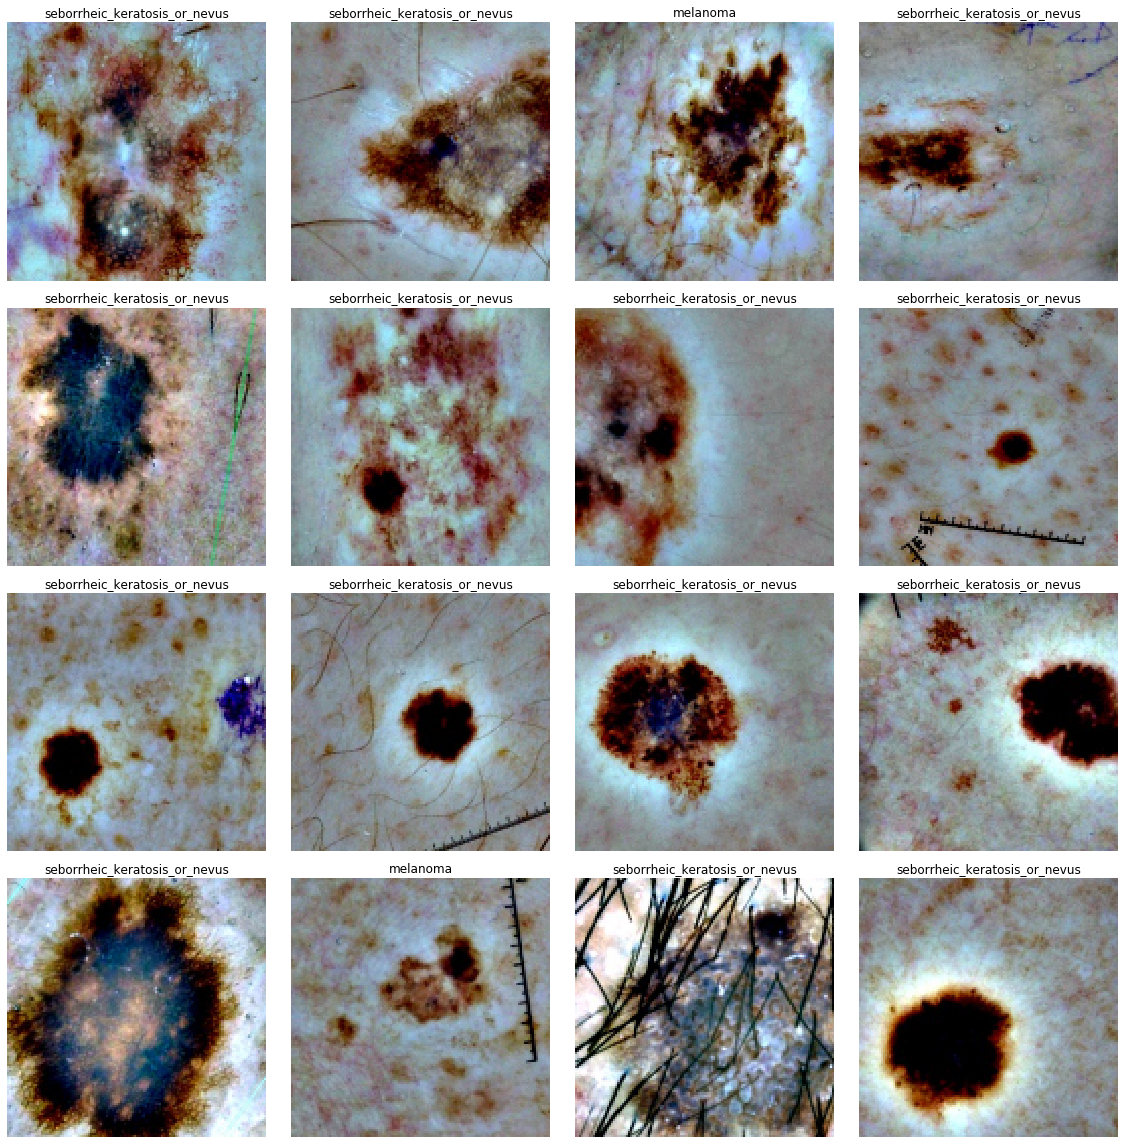

In [36]:
random_seed(1,True)
data.show_batch()

In [29]:
plot_multi(partial(_plot,img_index=1), 3, 3, figsize=(8,8))

NameError: name '_plot' is not defined

## Train

In [45]:
def train_and_return_metrics(data,seed,epochs):
    random_seed(seed,True)
    learner = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy, AUROC()],
                        callback_fns=[ShowGraph], 
                        pretrained=True)
    
        
    random_seed(seed,True)
    learner.fit_one_cycle(4,max_lr=slice(3e-3))
    accuracies = list(map(lambda x: x[1], learner.recorder.metrics))
    
    #Unfreeze
    learner.unfreeze()
    random_seed(seed,True)
    learner.fit_one_cycle(epochs, max_lr=slice(3e-4))
    
    accuracies += list(map(lambda x: x[1], learner.recorder.metrics))


    return accuracies

## Train Baseline

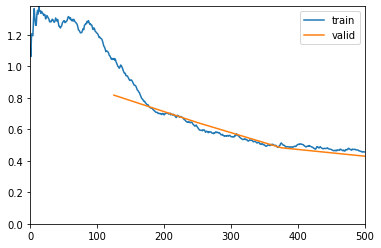

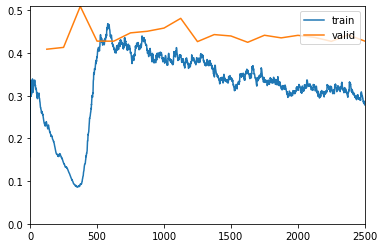

[tensor(0.7133),
 tensor(0.7600),
 tensor(0.8000),
 tensor(0.8267),
 tensor(0.8333),
 tensor(0.8267),
 tensor(0.8067),
 tensor(0.8067),
 tensor(0.8133),
 tensor(0.8000),
 tensor(0.8133),
 tensor(0.8200),
 tensor(0.8200),
 tensor(0.8200),
 tensor(0.8067),
 tensor(0.8400),
 tensor(0.8333),
 tensor(0.8400),
 tensor(0.8333),
 tensor(0.8467),
 tensor(0.8400),
 tensor(0.8400),
 tensor(0.8267),
 tensor(0.8467)]

In [46]:
data = reload_dataset(dm)
train_and_return_metrics(data,1,20)

## Train ben

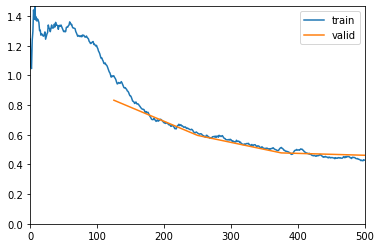

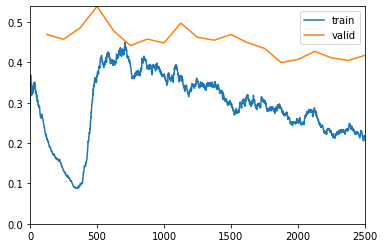

[tensor(0.6867),
 tensor(0.7867),
 tensor(0.7867),
 tensor(0.8267),
 tensor(0.8200),
 tensor(0.8400),
 tensor(0.8267),
 tensor(0.8333),
 tensor(0.8067),
 tensor(0.8133),
 tensor(0.8133),
 tensor(0.8133),
 tensor(0.8000),
 tensor(0.8133),
 tensor(0.8333),
 tensor(0.8200),
 tensor(0.8333),
 tensor(0.8400),
 tensor(0.8600),
 tensor(0.8533),
 tensor(0.8333),
 tensor(0.8600),
 tensor(0.8667),
 tensor(0.8467)]

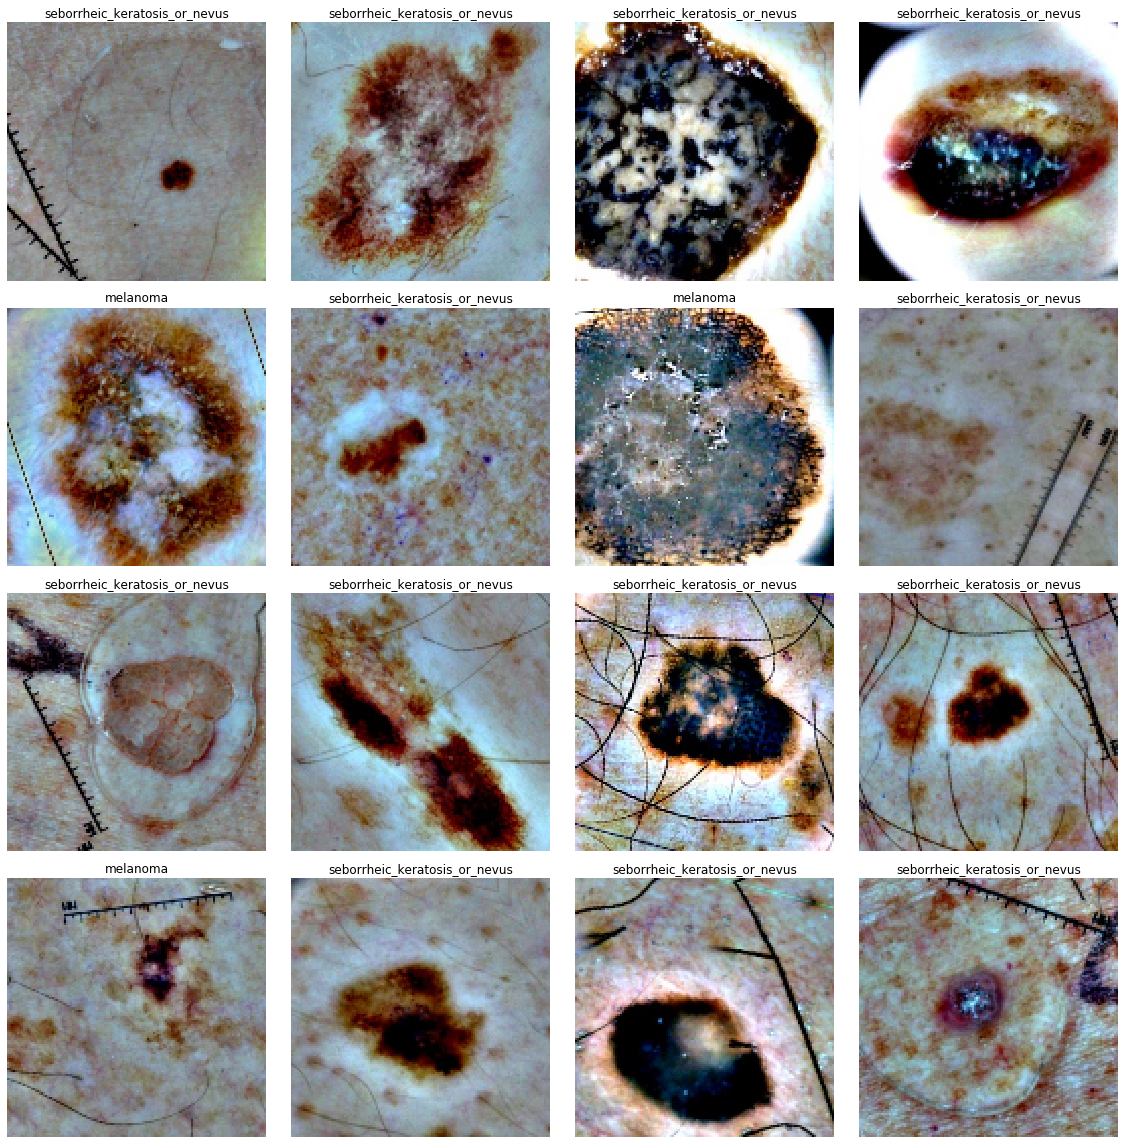

In [37]:
data = reload_dataset_ben(dm)
data.show_batch()
train_and_return_metrics(data,1,20)

# Comparison for various seeds

In [46]:
results_file_name = 'ben_analysis_seed'
columns = ['Baseline','ben_color_transform']

In [47]:
def write_results(seed,*args):
    f = open(f'{results_file_name}_{seed}.txt','w+')
    f.write(','.join(columns) + '\n')
    
    for epoch in zip(*args):
        line = ''
        for idx, variant in enumerate(epoch):
            line += str(variant.item())
            if idx != (len(epoch) - 1): 
                line += ','
            else: 
                line += '\n'
        
        f.write(line)


    f.close()

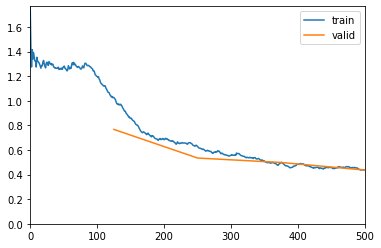

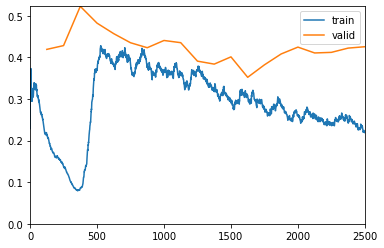

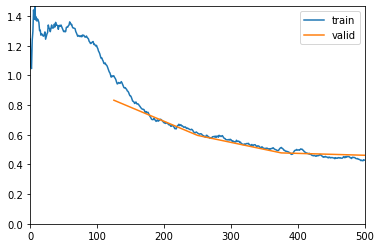

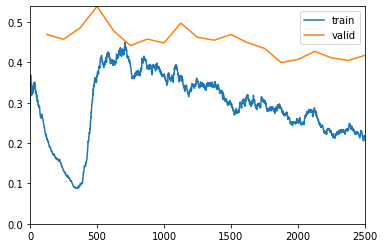

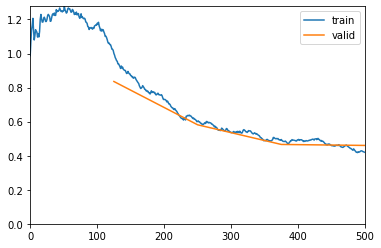

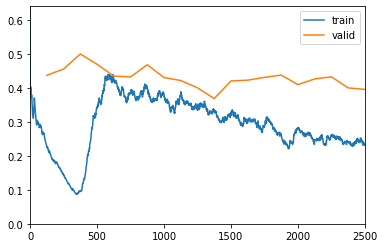

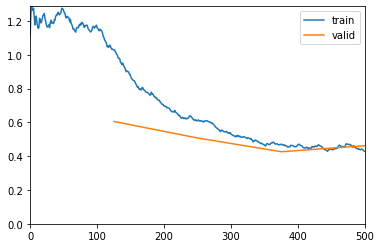

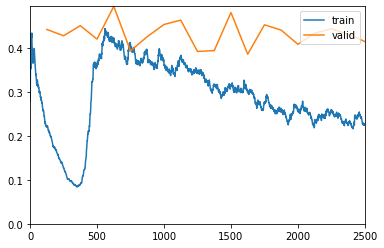

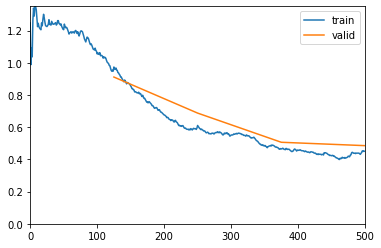

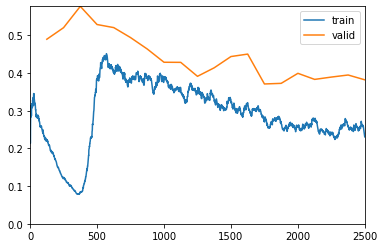

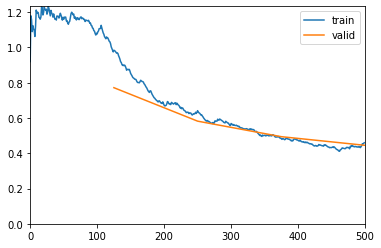

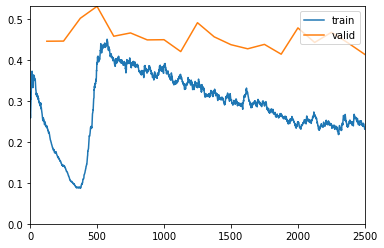

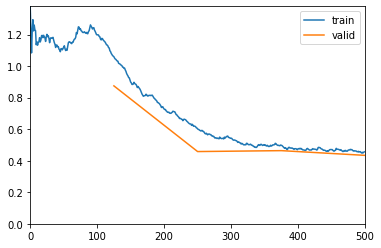

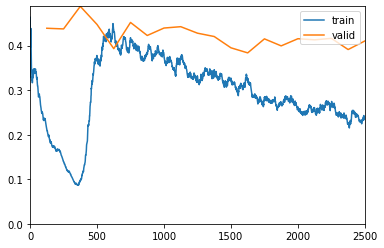

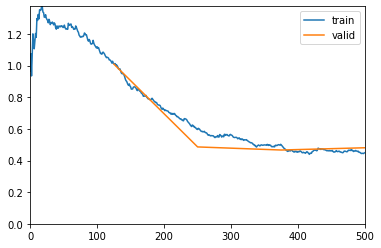

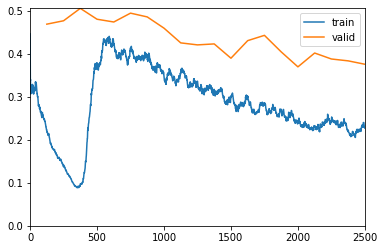

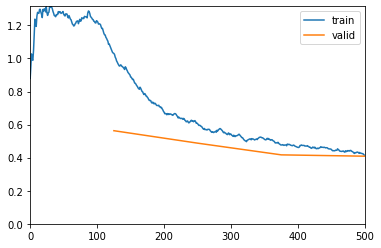

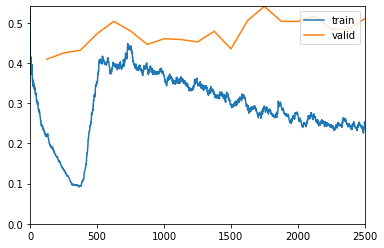

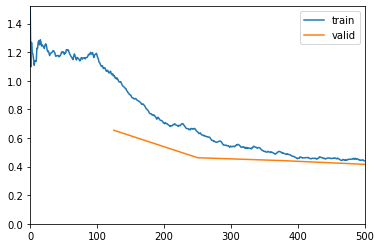

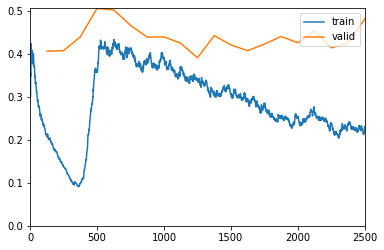

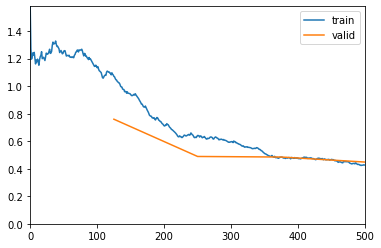

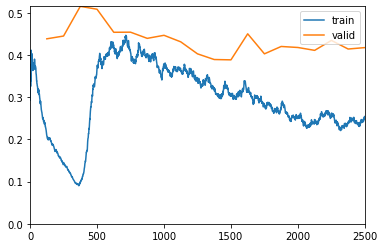

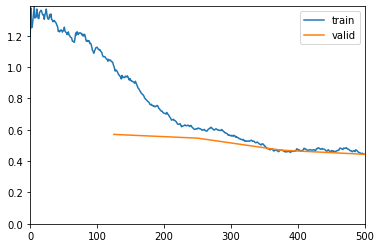

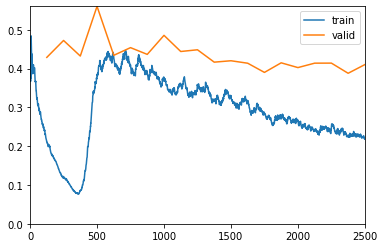

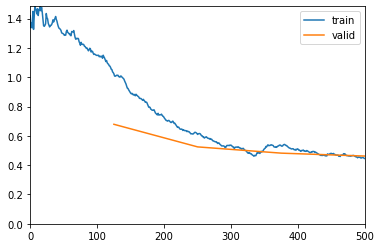

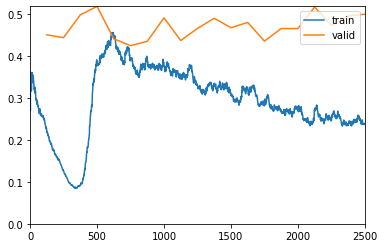

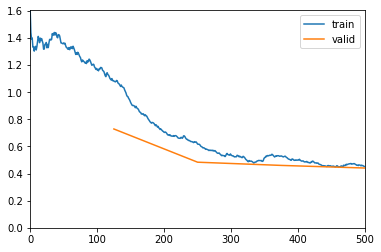

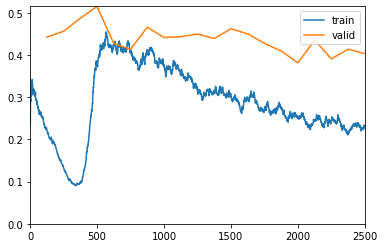

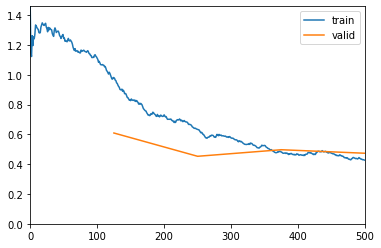

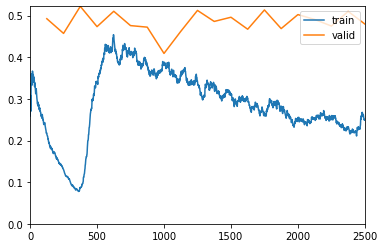

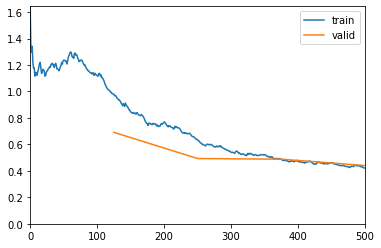

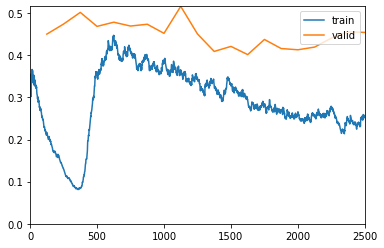

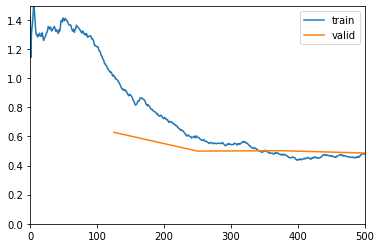

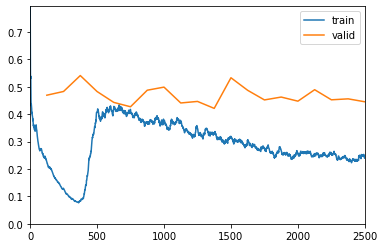

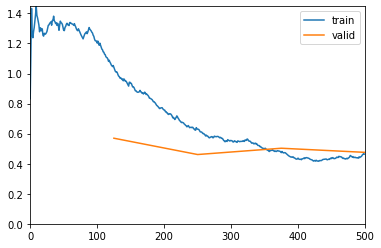

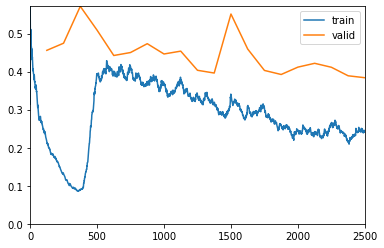

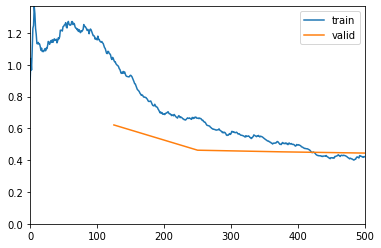

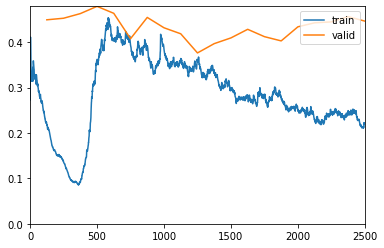

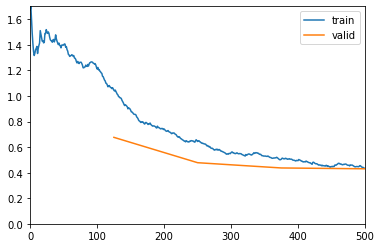

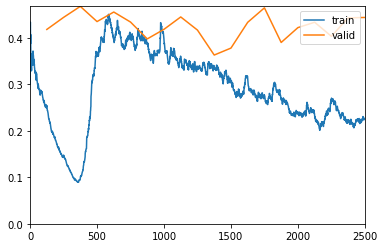

In [49]:
seeds = range(1,11)
epochs = 20

for seed in seeds:
    #Baseline
    data = reload_dataset(dm,seed=seed)    
    baseline_acc = train_and_return_metrics(data,seed,epochs)
    
    #ben
    data = reload_dataset_ben(dm,seed=seed)
    ben_acc = train_and_return_metrics(data,seed,epochs)

    write_results(seed, baseline_acc, ben_acc)
    

# Analyze results

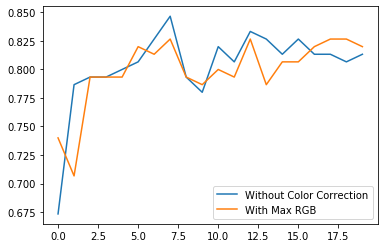

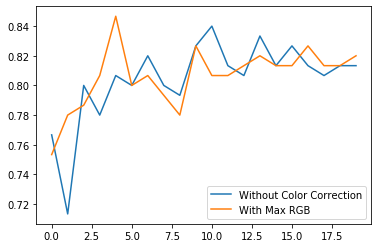

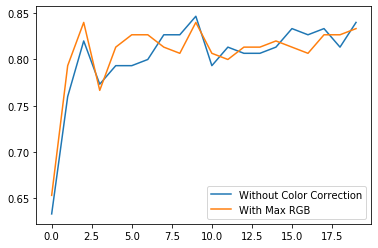

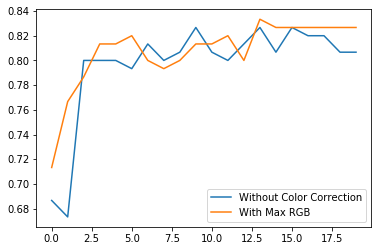

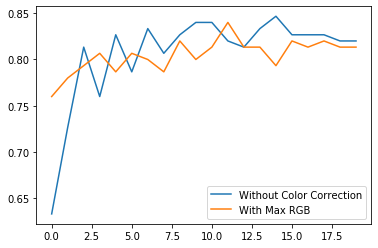

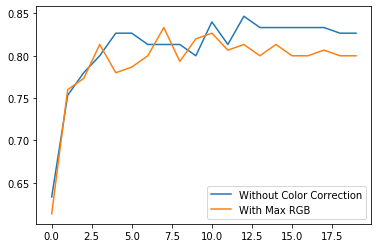

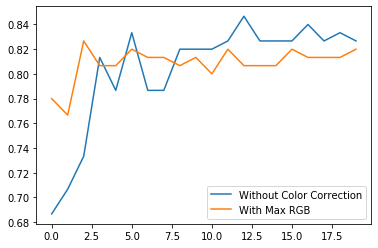

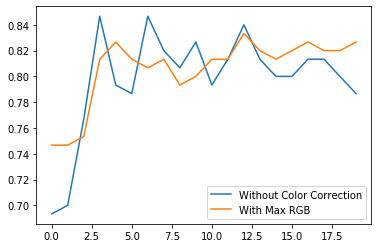

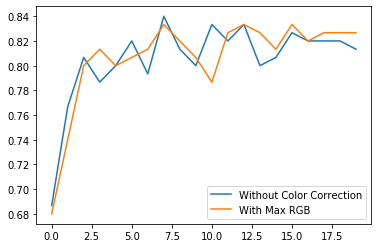

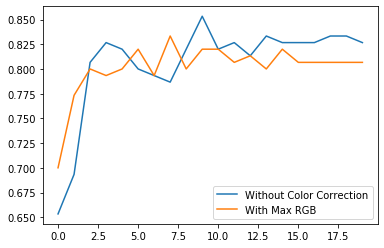

In [35]:
runs = {}
for i in range(1,11):
    runs[i] = pd.read_csv(f'{results_file_name}_{i}.txt')
#     runs[i] = pd.read_csv(f'fan_run_seed_{i}.txt')

    runs[i].plot()

In [37]:
max_acc_for_each_run_max_rgb = [runs[r].max()['With Max RGB'] for r in runs]
max_acc_for_each_run_baseline = [runs[r].max()['Without Color Correction'] for r in runs]


In [38]:
df = pd.DataFrame({
                    'Baseline':max_acc_for_each_run_baseline,
                    'Max RGB': max_acc_for_each_run_max_rgb
                })

In [39]:
df.describe()

Baseline    Max RGB
count  10.000000  10.000000
mean    0.844000   0.834667
std     0.007166   0.006126
min     0.826667   0.826667
25%     0.841667   0.833333
50%     0.846667   0.833333
75%     0.846667   0.838333
max     0.853333   0.846667

In [40]:
avg_max_rgb_acc = np.mean(max_acc_for_each_run_max_rgb)
std_max_rgb_acc = np.std(max_acc_for_each_run_max_rgb)



avg_baseline_acc = np.mean(max_acc_for_each_run_baseline)
std_baseline_acc = np.std(max_acc_for_each_run_baseline)

In [41]:
avg_max_rgb_acc,std_max_rgb_acc

(0.8346666514873504, 0.005811872022261097)

In [42]:
avg_baseline_acc,std_baseline_acc

(0.8440000116825104, 0.006798708410992281)

In [161]:


times_max_rgb_had_higher_acc = [runs[i].max()['Without Color Correction'] < runs[i].max()['With Max RGB'] for i in runs]

arl_effectiveness = sum(times_max_rgb_had_higher_acc)/ len(runs)

print(f'MAX RGB improved the Accuracy in {arl_effectiveness*100}% of the cases')

MAX RGB improved the Accuracy in 20.0% of the cases


# Shades of Gray

In [36]:
results_file_name = 'color_analysis_run_seed_shades'
columns = ['Without Color Correction','With Shades of Gray p=6']
def write_results(seed,first_learner,second_learner):
    l1 = list(map(lambda x: x[1], first_learner.recorder.metrics))
    l2 = list(map(lambda x: x[1], second_learner.recorder.metrics))

    f = open(f'{results_file_name}_{seed}.txt','w+')
    f.write(','.join(columns) + '\n')
    run = ''.join(map(str,[f'{a.item()},{b.item()}\n' for a,b in zip(l1,l2) ]))
    f.write(run)
    f.close()

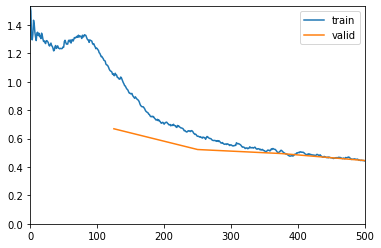

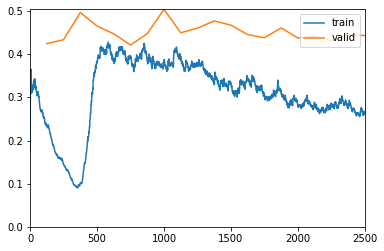

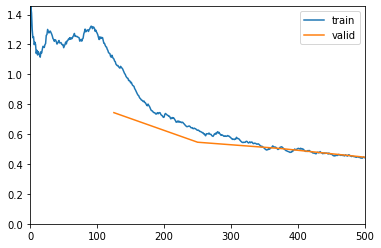

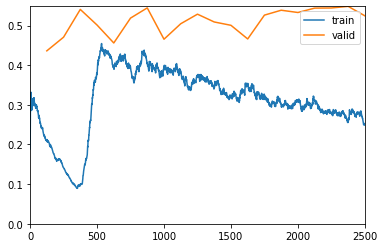

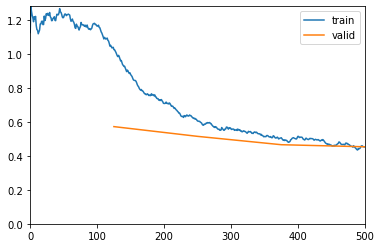

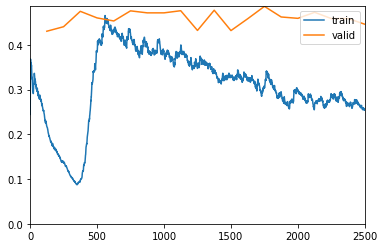

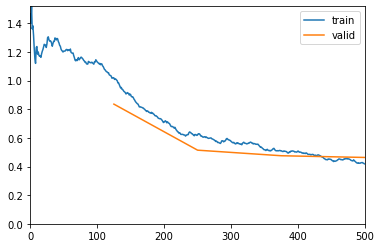

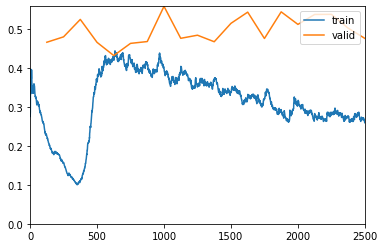

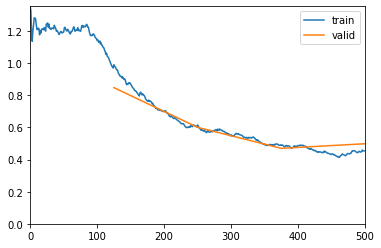

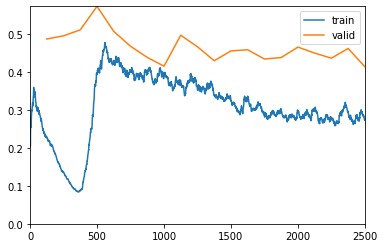

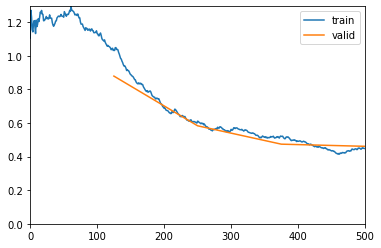

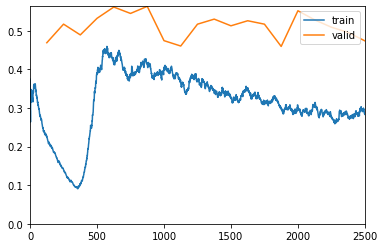

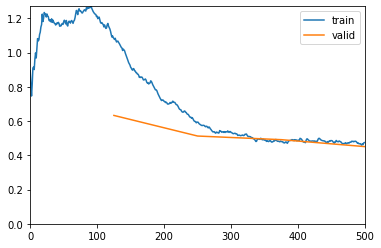

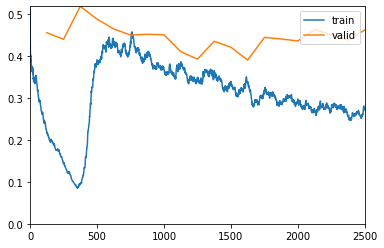

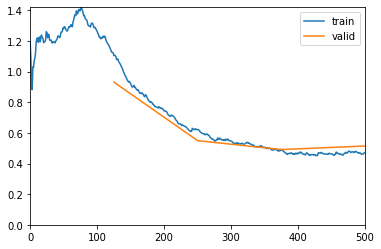

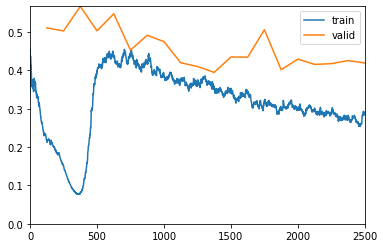

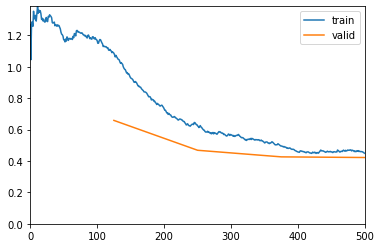

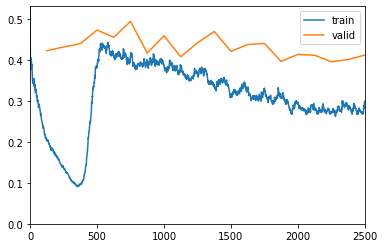

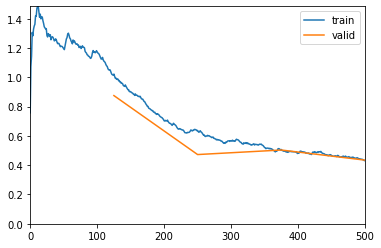

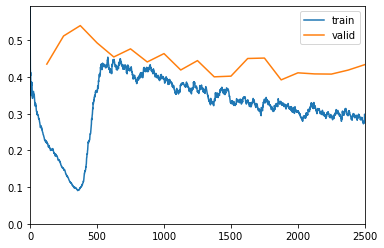

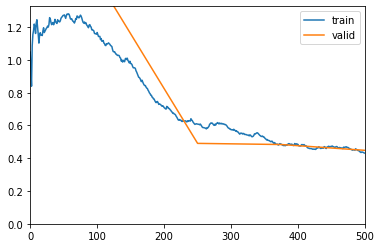

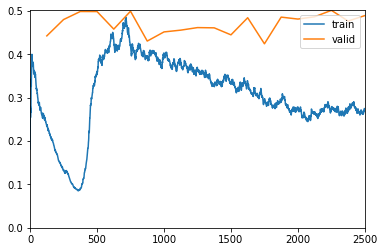

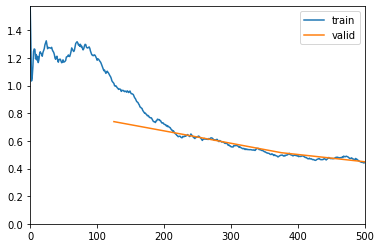

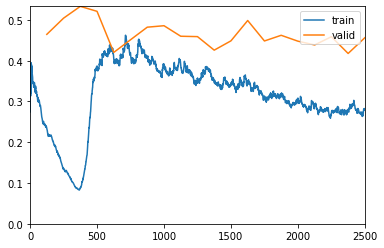

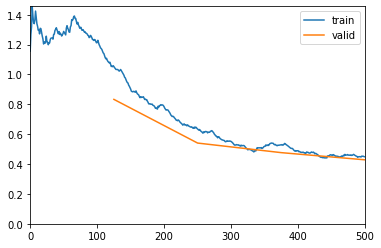

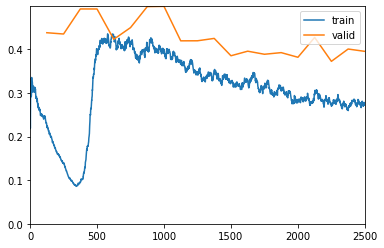

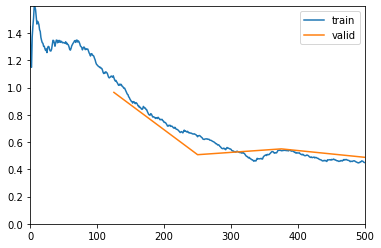

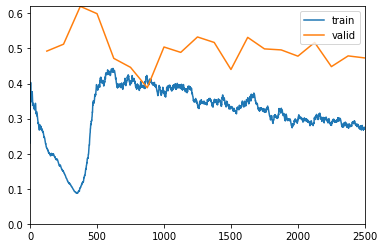

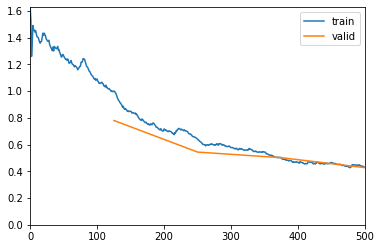

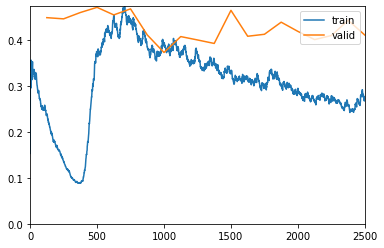

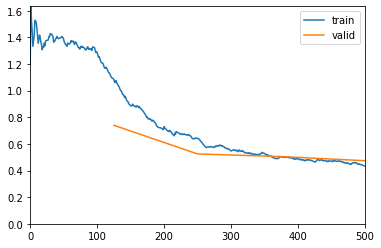

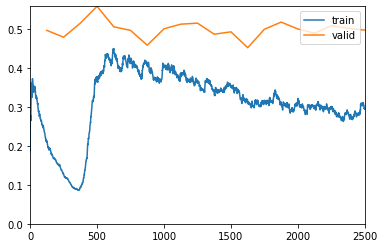

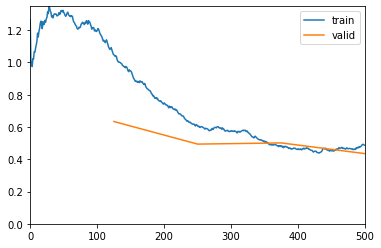

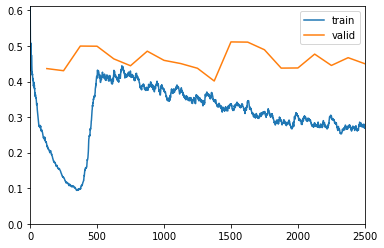

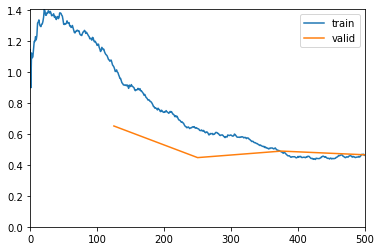

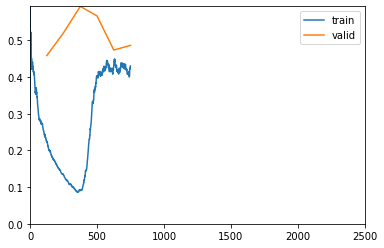

KeyboardInterrupt: 

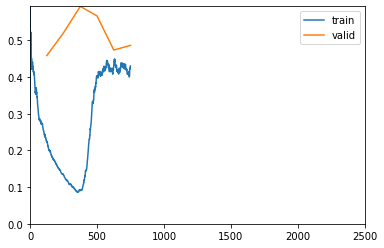

In [37]:
seeds = [1,2,3,4,5,6,7,8,9,10]
epochs = 20

for seed in seeds:
    data = reload_dataset(dm,seed)    
    random_seed(seed,True)
    
    #No color correction
    learn = simple_train(data,seed,epochs)

    
    #Con color correction
    data = reload_dataset(dm,seed)
    color_constancy_tfm = correct_color_shades_of_gray(p=6 ,gamma=1/2.2, order=0)
    data.train_ds.tfms.insert(0,color_constancy_tfm);
    data.valid_ds.tfms.insert(0,color_constancy_tfm);

    
    learn_color_correction = simple_train(data,seed,epochs)
    
    write_results(seed, learn, learn_color_correction)
    